In [36]:
from functions import *

In [37]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns

## Load data

### Choose inputs

In [38]:
W = 256
source_path = '../data/preprocessed/'
data_paths = ['lst', 'ndvi', 'lst/masked', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
list_rgb = [True,False,True,False]

In [39]:
data, time_slots = load_data(dir_paths,W,list_rgb)

In [40]:
inputs = 'ndvi' #'lst+ndvi' for ndvi inputs

In [41]:
data_inputs = data[dir_paths[0]]
ndvi = data[dir_paths[1]]
masked_inputs = data[dir_paths[2]]
data_targets = data[dir_paths[3]]
print('inputs shape:', data_inputs.shape,masked_inputs.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (34, 256, 256, 3) (34, 256, 256, 3) (34, 256, 256)
targets shape: (34, 256, 256)


In [42]:
if len(data_inputs) > 35:
  num_selected = 34

  # Select 35 random indices from the 108 images
  selected_indices = np.random.choice(data_inputs.shape[0], size=num_selected, replace=False)

  # Extract the selected images using the random indices
  selected_inputs = data_inputs[selected_indices]
  selected_targets = data_targets[selected_indices]


Convert inputs to gray images

In [43]:
masked_gray_inputs = []
gray_inputs = []
for i in range(masked_inputs.shape[0]):
  masked_img_rgb = masked_inputs[i]
  masked_img_gray = np.dot(masked_img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  masked_gray_inputs.append(masked_img_gray)

  img_rgb = data_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  gray_inputs.append(img_gray)

masked_gray_inputs = np.array(masked_gray_inputs)
print(masked_gray_inputs.shape)

gray_inputs = np.array(gray_inputs)
print(gray_inputs.shape)

(34, 256, 256)
(34, 256, 256)


Split data

In [44]:
if inputs == 'lst':
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(data_inputs, data_targets)
else:
  ndvi_expanded = np.expand_dims(ndvi, axis=-1)  # Shape: (n_samples, 256, 256, 1)

  # Combine LST (RGB) y NDVI in a 4 channel input data
  combined_input = np.concatenate([data_inputs, ndvi_expanded], axis=-1)  # Shape: (n_samples, 256, 256, 4)
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(combined_input, data_targets)

## CNN simpler

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_simplified_cnn_model(input_shape):
    model = models.Sequential()

    # Capa 1: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa 2: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa de aplanamiento
    model.add(layers.Flatten())

    # Capa densa
    model.add(layers.Dense(64, activation='relu'))

    # Capa de salida con activación lineal (para predicciones de temperatura)
    model.add(layers.Dense(256 * 256, activation='linear'))

    # Reshape de la salida a la forma (256, 256)
    model.add(layers.Reshape((256, 256)))

    return model

# Construir el modelo
if len(train_input.shape) == 3:
  input_shape = train_input.shape[1:]+(1,)
else:
  input_shape = train_input.shape[1:]  # Assuming data_inputs is your dataset


In [46]:
simplified_cnn_model = build_simplified_cnn_model(input_shape)
simplified_cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
simplified_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 16)      592       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 123008)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [47]:
tf.keras.utils.plot_model(simplified_cnn_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [49]:
history = simplified_cnn_model.fit(train_input, train_target, batch_size=4, epochs=10, validation_data=(validation_input, validation_target))

Epoch 1/10
7/7 [==============================] - 1s 58ms/step - loss: 1.3568 - mae: 0.2476 - val_loss: 0.5789 - val_mae: 0.3163
Epoch 2/10
7/7 [==============================] - 0s 53ms/step - loss: 0.6370 - mae: 0.2979 - val_loss: 0.3632 - val_mae: 0.1965
Epoch 3/10
7/7 [==============================] - 0s 49ms/step - loss: 0.5058 - mae: 0.2115 - val_loss: 0.2645 - val_mae: 0.1533
Epoch 4/10
7/7 [==============================] - 0s 48ms/step - loss: 0.4137 - mae: 0.1787 - val_loss: 0.2143 - val_mae: 0.1177
Epoch 5/10
7/7 [==============================] - 0s 48ms/step - loss: 0.3497 - mae: 0.1396 - val_loss: 0.1733 - val_mae: 0.0958
Epoch 6/10
7/7 [==============================] - 0s 66ms/step - loss: 0.2741 - mae: 0.1248 - val_loss: 0.1482 - val_mae: 0.1048
Epoch 7/10
7/7 [==============================] - 0s 58ms/step - loss: 0.2199 - mae: 0.1085 - val_loss: 0.1759 - val_mae: 0.0883
Epoch 8/10
7/7 [==============================] - 0s 56ms/step - loss: 0.1755 - mae: 0.0970 - val

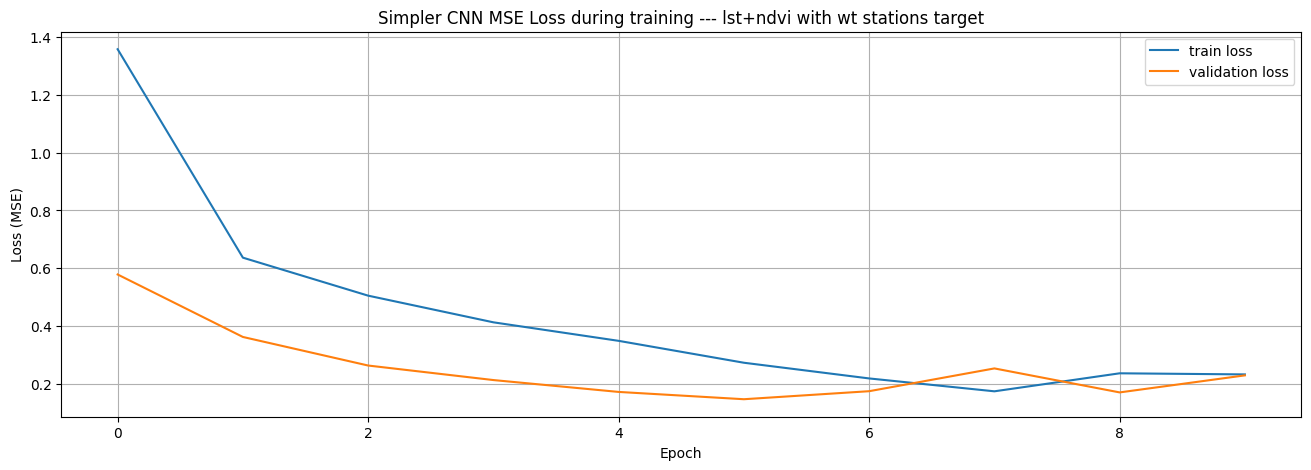

In [50]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt stations target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [51]:
plt.savefig('../plots/cnn.png')

<Figure size 640x480 with 0 Axes>

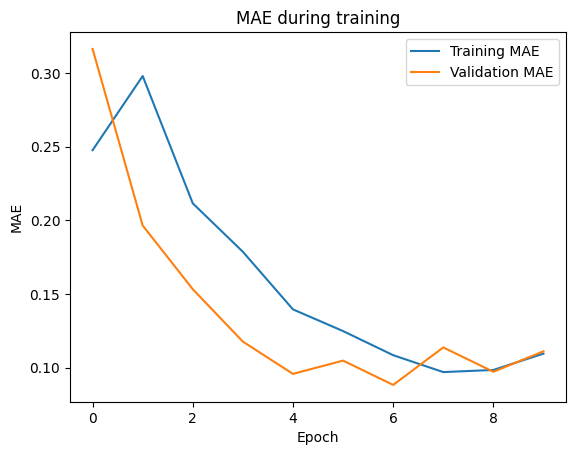

In [52]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

In [53]:
# Evaluar el modelo en el conjunto de validación
loss, mae = simplified_cnn_model.evaluate(validation_input, validation_target)

print(f'Pérdida (MSE) en validación: {loss}')
print(f'MAE en validación: {mae}')

1/1 [==============================] - 0s 23ms/step - loss: 0.2305 - mae: 0.1111
Pérdida (MSE) en validación: 0.2305402308702469
MAE en validación: 0.11110857129096985


In [54]:
validation_prediction = simplified_cnn_model.predict(validation_input)
test_prediction = simplified_cnn_model.predict(test_input)

1/1 [==============================] - 0s 22ms/step


In [55]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

test_target_flat = test_target.reshape(-1)
test_prediction_flat = test_prediction.reshape(-1)

In [56]:
val_target_mask = validation_target_flat[validation_target_flat!= 0]
val_pred_mask = validation_prediction_flat[validation_target_flat!= 0]
test_target_mask = test_target_flat[test_target_flat!= 0]
test_pred_mask = test_prediction_flat[test_target_flat!= 0]

Overall results

In [57]:
results = evaluate_model(val_target_mask, val_pred_mask)
print('Validation results')
for k,v in results.items():
  print(k,':',v)

Validation results
MAE : 1.2522288528628667
MSE : 13.923519770749762
RMSE : 1.9192170515642766
R² : 0.714663757741558
MAPE (%) : 75843.99009117814
MSE sample-wise : 3.683394091015075


In [58]:
results = evaluate_model(test_target_mask, test_pred_mask)
print('Test results')
for k,v in results.items():
  print(k,':',v)

Test results
MAE : 1.215516843798488
MSE : 1.009308056545171
RMSE : 2.3340922940045705
R² : 0.7352378069799408
MAPE (%) : 57110.266790144
MSE sample-wise : 5.447986836931519


Image wise metrics results

In [59]:
c = 0
mean_results = {k:[] for k in results.keys()}
# Loop through each sample and compute the MSE for that sample
for i in range(test_target.shape[0]):
    samples_per_image = test_target.shape[1]*test_target.shape[2]
    # Flatten the true and predicted values for this sample
    y_true_flatten = test_target_flat[c:c+samples_per_image]
    y_true_mask = y_true_flatten[y_true_flatten!= 0]

    y_pred_flatten = test_prediction_flat[c:c+samples_per_image]
    y_pred_mask = y_pred_flatten[y_true_flatten!= 0]

    #print(y_true_flatten.shape,y_pred_flatten.shape)
    # Calculate MSE for this sample
    mse = mean_squared_error(y_true_mask, y_pred_mask)
    res = evaluate_model(y_true_mask, y_pred_mask)

    for k,v in res.items():
      mean_results[k].append(v)


    c += samples_per_image

for key in mean_results:
    mean_results[key] = np.mean(mean_results[key])

print(mean_results)

{'MAE': 1.215516843798488, 'MSE': 18.059448032085395, 'RMSE': 1.793122587226074, 'R²': 0.8092855613845851, 'MAPE (%)': 57110.266790144, 'MSE sample-wise': 5.44798683693152}


See what are the areas with more prediction error

In [60]:
diff = validation_prediction - validation_target

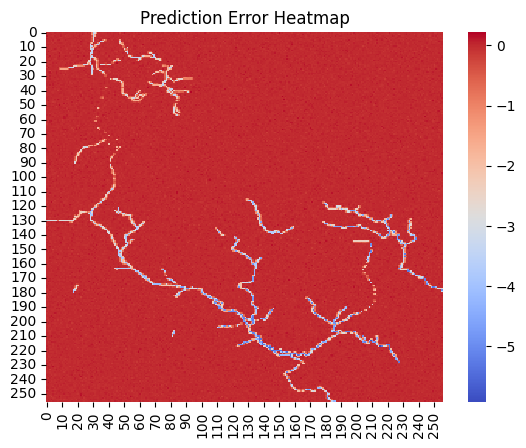

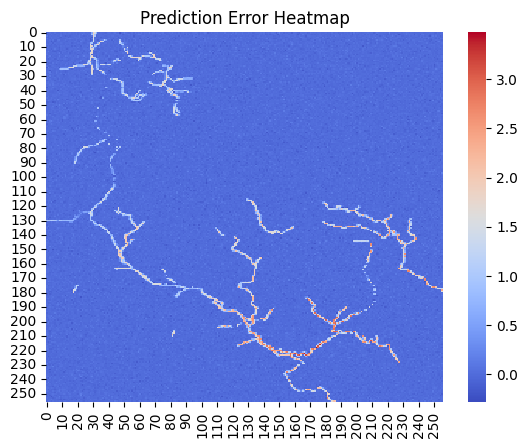

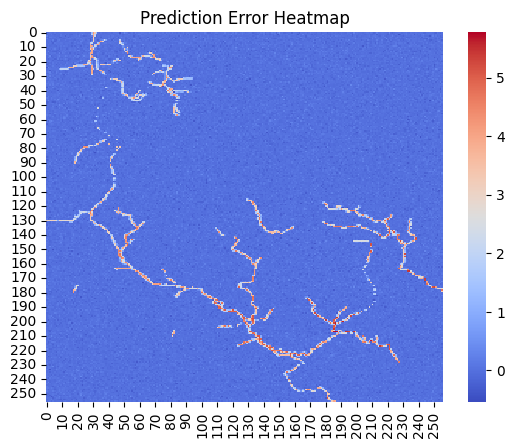

In [61]:
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

Dispersion graph and histogram of prediction errors

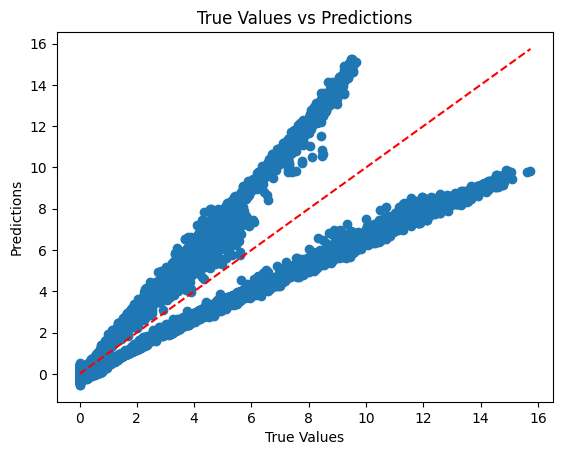

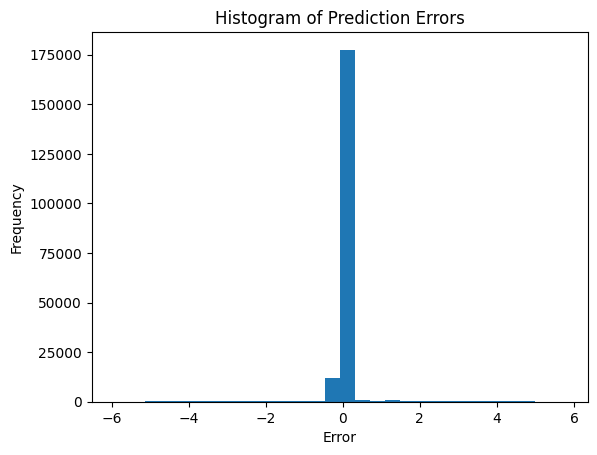

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


#### Save model results

In [64]:
model_name = "CNN_Simpler_model"
details = {'Input': '34 lst+ndvi scaled', 'Output': 'Water stations', 'Resolution': 256, 'Batch size': 4, 'Epochs': 10}

file_path = "../results/model_results_img_wise.xlsx"
save_excel(file_path, model_name, mean_results, excel = 'Results')

file_path = "../results/model_details.xlsx"
save_excel(file_path, model_name, details, excel = 'Details')